# Tarea Reconocimiento del Habla

La dependencia temporal es caracterizada en forma matemática por las redes Bayesianas, en las cuales los valores futuros solamente dependen de los valores recientemente observados. Tal como en redes Bayesianas con probabilidades discretas, tambi\'en es posible estudiar secuencias temporales discretas.

Estas secuencias se dan en muchas problemas en que necesitamos clasificar el estado de un proceso (oculto o latente) $Z$ que toma valores (discretos o contínuos) a los que tenemos acceso a través de  variables observadas $X$.  

Sin embargo, si sabemos que el proceso $Z$ tiene la propiedad de Markov de primer orden $p(z_k \vert z_{k-1},\ldots,z_1)=p(z_k \vert z_{k-1})$ y que las observaciones $X$ son independientes entre si y solamente dependen de la variable oculta.

# Descriptores de audio

La Densidad Espectral de una señal es una función matemática que nos informa de cómo está distribuida la potencia de dicha señal sobre las distintas componentes de frecuencias sobre las que está formada. El espectrograma consiste en utilizar un determinado número de muestras por medio de una ventana temporal, con un tamaño específico. A continuación se hace el cálculo del contenido frecuencial de las muestras puestas en ventana, y se representan en una gráfica en tres dimensiones.

Seguidamente se desplaza la ventana a lo largo del tiempo de la señal, para escoger otro número de muestras diferentes, se vuelve a calcular el contenido frecuencial y se vuelve a representar en la misma gráfica que la anterior. Esta operación se repite sucesivamente a lo largo de la señal.

La suma de la representación de las transformadas de Fourier de las ventanas consecutivas, aporta información en el dominio frecuencial de la señal, y de la variación de la energía y la frecuencia en función del tiempo.

Una vez puesta en ventana la señal, se calcula de la Transformada de Fourier de Tiempo Reducido (STFT) del conjunto de muestras puestas en ventana. El STFT es un método de procesamiento de señales no estacionarias en las que las características estadísticas varían en función del tiempo. El STFT extrae varias tramas de una señal que son analizadas en cada uno de los desplazamientos de la ventana a lo largo del tiempo.

El desplazamiento de la ventana puede ser solapado para asegurar que las discontinuidades que se producen entre tramas no pasen por alto y se analicen en el desplazamiento de la trama siguiente, a este solapamiento de tramas también se le conoce como overlap

In [3]:
from python_speech_features import mfcc
from python_speech_features import logfbank
import scipy.io.wavfile as wav
import os
import numpy as np

def extract_mfcc(path,nfilt,nfft):
    rate,sig =  wav.read(path)
    fbank_feat = logfbank(sig, rate, nfft=nfft)
    return fbank_feat

def build_data_set(dir,nfilt=26,nfft=512,split=0.8):
    file_list = [f for f in os.listdir(dir) if os.path.splitext(f)[1] == '.wav']
    train_dataset = []
    test_dataset = []
    (num_frames,ncep) = extract_mfcc(dir+"/"+file_list[0],nfilt,nfft).shape
    train_size=int(len(file_list)*split)
    for file_name in file_list[:train_size]:
        path=dir+"/"+file_name
        feature = extract_mfcc(path,nfilt,nfft)
        #if feature.shape==(num_frames,ncep):
        train_dataset.append(feature)
    for file_name in file_list[train_size:]:
        path=dir+"/"+file_name
        feature = extract_mfcc(path,nfilt,nfft)
        #if feature.shape==(num_frames,ncep):
        test_dataset.append(feature)
    return train_dataset,test_dataset

In [4]:
yes_train_features,yes_test_features=build_data_set('yes')

In [7]:
print(len(yes_train_features)),print(len(yes_test_features))

3235
809


(None, None)

In [8]:
down_train_features,down_test_features=build_data_set('down')

In [10]:
print(len(down_train_features)),print(len(down_test_features))

3133
784


(None, None)

In [11]:
go_train_features,go_test_features=build_data_set('go')

In [12]:
print(len(go_train_features)),print(len(go_test_features))

3104
776


(None, None)

In [13]:
left_train_features,left_test_features=build_data_set('left')

In [14]:
print(len(left_train_features)),print(len(left_test_features))

3040
761


(None, None)

In [15]:
off_train_features,off_test_features=build_data_set('off')

In [16]:
print(len(off_train_features)),print(len(off_test_features))

2996
749


(None, None)

In [17]:
on_train_features,on_test_features=build_data_set('on')

In [18]:
print(len(on_train_features)),print(len(on_test_features))

3076
769


(None, None)

In [19]:
right_train_features,right_test_features=build_data_set('right')

In [20]:
print(len(right_train_features)),print(len(right_test_features))

3022
756


(None, None)

In [21]:
stop_train_features,stop_test_features=build_data_set('stop')

In [22]:
print(len(stop_train_features)),print(len(stop_test_features))

3097
775


(None, None)

In [23]:
up_train_features,up_test_features=build_data_set('up')

In [24]:
print(len(up_train_features)),print(len(up_test_features))

2978
745


(None, None)

In [25]:
no_train_features,no_test_features=build_data_set('no')

In [26]:
print(len(no_train_features)),print(len(no_test_features))

3152
789


(None, None)

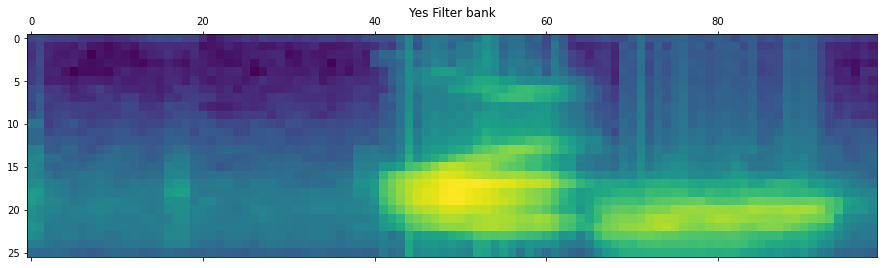

In [27]:
import matplotlib.pyplot as plt
filterbank_features = yes_train_features[0].T
plt.matshow(filterbank_features)
plt.title('Yes Filter bank')

plt.show()

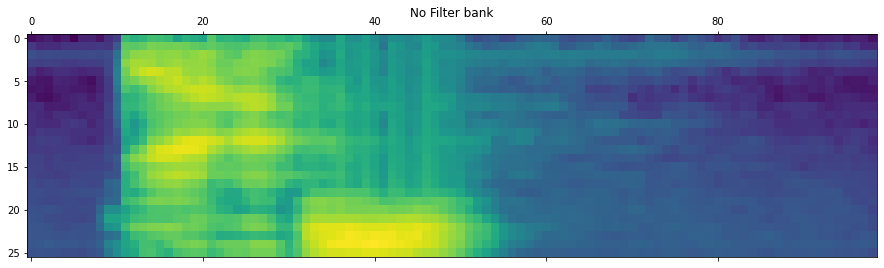

In [28]:
filterbank_features = yes_test_features[6].T
plt.matshow(filterbank_features)
plt.title('No Filter bank')

plt.show()

## Modelo HMM Gaussiano

Las variables observadas pueden ser variables discretas o continuas. Cuando se consideran v.a. discretas, podemos especificar una matriz $\boldsymbol{A}_{[N \times N]}$ de transición para los $N$ posibles estados, una matriz de emisión $\boldsymbol{B}_{[M \times N]}$ y un conjunto de probabilidades iniciales $\boldsymbol{\pi}$.

1. Filtrado : Determinar $p(z_n \vert X_n)$.
2. Verosimilitud Determinar $p(X_n)$. 
3. Secuencia más probable} $p(Z_n \vert X_n)$.

In [29]:
import numpy as np
from hmmlearn import hmm

train_features={'yes':yes_train_features,'no':no_train_features,'up':up_train_features,'down':down_train_features,'right':right_train_features,
               'left':left_train_features,'go':go_train_features,'off':off_train_features,'on':on_train_features,'stop':stop_train_features}

n_components=3
covariance_type="diag"

#”spherical” — each state uses a single variance value that applies to all features.
#”diag” — each state uses a diagonal covariance matrix.
#”full” — each state uses a full (i.e. unrestricted) covariance matrix.
#”tied” — all states use the same full covariance matrix.

models={i:hmm.GaussianHMM(n_components=n_components, covariance_type=covariance_type) for i in train_features.keys()}

In [30]:
models

{'yes': GaussianHMM(n_components=3),
 'no': GaussianHMM(n_components=3),
 'up': GaussianHMM(n_components=3),
 'down': GaussianHMM(n_components=3),
 'right': GaussianHMM(n_components=3),
 'left': GaussianHMM(n_components=3),
 'go': GaussianHMM(n_components=3),
 'off': GaussianHMM(n_components=3),
 'on': GaussianHMM(n_components=3),
 'stop': GaussianHMM(n_components=3)}

In [32]:
for label,model in models.items():
    time_steps=[]
    num_samples=len(train_features[label])
    for i in train_features[label]:
        time_s=i.shape[0]
        time_steps.append(time_s)
    num_features=i.shape[1]
    data_sample=np.concatenate(train_features[label])
    model.fit(data_sample,lengths=time_steps)
    print('label : {0}, score : {1:.2f}'.format(label,model.score(data_sample)/num_samples))

label : yes, score : -6219.13
label : no, score : -6106.46
label : up, score : -6065.22
label : down, score : -6142.34
label : right, score : -6231.38
label : left, score : -6211.94
label : go, score : -6084.04
label : off, score : -6103.66
label : on, score : -6093.07
label : stop, score : -6251.35


In [37]:
from scipy.special import logsumexp

test_features={'yes':yes_test_features,'no':no_test_features,'up':up_test_features,'down':down_test_features,'right':right_test_features,
               'left':left_test_features,'go':go_test_features,'off':off_test_features,'on':on_test_features,'stop':stop_test_features}
normalize = lambda p,v : np.exp(p-logsumexp(v))

for label in models.keys():
    print('----------------------------------------------------------------')
    time_steps=[]
    num_samples=len(train_features[label])
    for i in train_features[label]:
        time_s=i.shape[0]
        time_steps.append(time_s)
    num_features=i.shape[1]
    data_sample=np.concatenate(train_features[label])
    potential=dict()
    for pred,model in models.items():
        score=model.score(data_sample)
        print('true label : {0}, pred label {1}, score : {2:.2f}'.format(label,pred,score))
        potential.update({pred:score})
    prob={k:normalize(v,list(potential.values())) for k,v in potential.items()}
    print('Conditional probability : {0}|{1}'.format(label,prob))

----------------------------------------------------------------
true label : yes, pred label yes, score : -20118889.61
true label : yes, pred label no, score : -21438724.15
true label : yes, pred label up, score : -21074914.13
true label : yes, pred label down, score : -21319380.37
true label : yes, pred label right, score : -20710945.31
true label : yes, pred label left, score : -20407150.25
true label : yes, pred label go, score : -21188393.80
true label : yes, pred label off, score : -20736424.56
true label : yes, pred label on, score : -21412507.37
true label : yes, pred label stop, score : -20377335.01
Conditional probability : yes|{'yes': 1.0, 'no': 0.0, 'up': 0.0, 'down': 0.0, 'right': 0.0, 'left': 0.0, 'go': 0.0, 'off': 0.0, 'on': 0.0, 'stop': 0.0}
----------------------------------------------------------------
true label : no, pred label yes, score : -20099040.26
true label : no, pred label no, score : -19247569.13
true label : no, pred label up, score : -19495111.17
true la

In [68]:
def test_models(labels,models,features):
    true_label=[]
    pred_label=[]
    for label in models.keys():
        num_samples = len(test_features[label])
        time_steps = []
        for i in test_features[label]:
            time_s = i.shape[0]
            time_steps.append(time_s)
        num_features=i.shape[1]
        for i in range(num_samples):
            potential=dict()
            for pred,model in models.items():
                score=model.score(features[label][i])
                potential.update({pred:score})
            prob={k:normalize(v,list(potential.values())) for k,v in potential.items()}
            max_pred=max(prob, key=prob.get)
            true_label.append(labels[label])
            pred_label.append(labels[max_pred])
    return true_label,pred_label

In [70]:
labels={'yes': 0, 'no':1,'up':2,'down':3,'right':4,'left':5,'go':6,'off':7,'on':8,'stop':9}
y_true,y_pred=test_models(labels,models,test_features)

In [71]:
from sklearn.metrics import classification_report

target_names = list(labels.keys())
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         yes       0.70      0.56      0.62       809
          no       0.34      0.24      0.28       789
          up       0.16      0.48      0.25       745
        down       0.22      0.41      0.29       784
       right       0.38      0.13      0.20       756
        left       0.33      0.19      0.24       761
          go       0.31      0.22      0.25       776
         off       0.40      0.26      0.32       749
          on       0.46      0.13      0.21       769
        stop       0.35      0.43      0.38       775

    accuracy                           0.31      7713
   macro avg       0.37      0.30      0.30      7713
weighted avg       0.37      0.31      0.30      7713



In [72]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_true, y_pred))

[[451   6 131  57  28  37   5  16   2  76]
 [  3 188 168 205  10  26 116  24  20  29]
 [  3  18 358 114  11  20  15  59  14 133]
 [  9  80 163 321  24  41  81  19  25  21]
 [ 22  46 225 161  99  83  51  16   9  44]
 [ 67  17 257  76  31 141  19  51   5  97]
 [  5 118 166 199  11  35 168  27  18  29]
 [ 13  11 241  78  14  16  13 196  20 147]
 [  1  60 224 196  11  18  68  40 103  48]
 [ 66   6 242  38  19  10   9  47   7 331]]
